# House Price Regression using Boston Housing Price Dataset

In [1]:
# Loading the Data
from keras.datasets import boston_housing
(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

print(f"\n\ntrain_data.shape: {train_data.shape}, test_data.shape: {test_data.shape},\ntrain_targets.shape: {train_targets.shape}, test_targets.shape: {test_targets.shape}")

2024-07-06 11:01:07.887210: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-06 11:01:07.897448: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-06 11:01:07.995575: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-06 11:01:08.153380: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-06 11:01:08.301302: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registe



train_data.shape: (404, 13), test_data.shape: (102, 13),
train_targets.shape: (404,), test_targets.shape: (102,)


In [2]:
train_targets # notice continuous not discrete

array([15.2, 42.3, 50. , 21.1, 17.7, 18.5, 11.3, 15.6, 15.6, 14.4, 12.1,
       17.9, 23.1, 19.9, 15.7,  8.8, 50. , 22.5, 24.1, 27.5, 10.9, 30.8,
       32.9, 24. , 18.5, 13.3, 22.9, 34.7, 16.6, 17.5, 22.3, 16.1, 14.9,
       23.1, 34.9, 25. , 13.9, 13.1, 20.4, 20. , 15.2, 24.7, 22.2, 16.7,
       12.7, 15.6, 18.4, 21. , 30.1, 15.1, 18.7,  9.6, 31.5, 24.8, 19.1,
       22. , 14.5, 11. , 32. , 29.4, 20.3, 24.4, 14.6, 19.5, 14.1, 14.3,
       15.6, 10.5,  6.3, 19.3, 19.3, 13.4, 36.4, 17.8, 13.5, 16.5,  8.3,
       14.3, 16. , 13.4, 28.6, 43.5, 20.2, 22. , 23. , 20.7, 12.5, 48.5,
       14.6, 13.4, 23.7, 50. , 21.7, 39.8, 38.7, 22.2, 34.9, 22.5, 31.1,
       28.7, 46. , 41.7, 21. , 26.6, 15. , 24.4, 13.3, 21.2, 11.7, 21.7,
       19.4, 50. , 22.8, 19.7, 24.7, 36.2, 14.2, 18.9, 18.3, 20.6, 24.6,
       18.2,  8.7, 44. , 10.4, 13.2, 21.2, 37. , 30.7, 22.9, 20. , 19.3,
       31.7, 32. , 23.1, 18.8, 10.9, 50. , 19.6,  5. , 14.4, 19.8, 13.8,
       19.6, 23.9, 24.5, 25. , 19.9, 17.2, 24.6, 13

### Preprocessing


In [3]:
# Feature Normalization
mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std
test_data -= mean
test_data /= std

### Model Definition

In [4]:
import keras
from keras import layers

def build_model():
    model = keras.Sequential([
        layers.Dense(64, activation="relu"),
        layers.Dense(64, activation="relu"),
        layers.Dense(1)
    ])
    model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
    return model

# The last layer could have had an activation and a reverse scaler could be used

### K-fold Validation
- we have a small dataset<br><br>
- training set would be too small and validation results would have a high variance depending on how data is split<br><br>
- a solution is to use K-fold validation
-- where data is split into K-partitions and only one partition is used for validation, other K-1 partitions are used for training

-- the same model is used for each partition 

In [5]:
# K-fold validation
import numpy as np

k = 4
num_val_samples = len(train_data) // k
num_epochs = 100
all_scores = []
for i in range(k):
    print(f"Processing fold #{i}")
    val_data = train_data[i * num_val_samples : (i+1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples : (i+1) * num_val_samples]
    partial_train_data = np.concatenate(
        [
        train_data[: i * num_val_samples],
        train_data[(i+1) * num_val_samples :]
        ],
        axis=0
    )
    partial_train_targets = np.concatenate(
        [
            train_targets[: i * num_val_samples],
            train_targets[(i+1) * num_val_samples :]
        ],
        axis=0
    )
    model = build_model()
    model.fit(
        partial_train_data, 
        partial_train_targets, 
        epochs=num_epochs,
        batch_size=16, 
        verbose=0
        )
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)

print(f"scores: {all_scores}")

Processing fold #0
Processing fold #1
Processing fold #2
Processing fold #3
scores: [2.0228521823883057, 2.4750993251800537, 2.601799488067627, 2.485825538635254]


In [6]:
# In the K-fold validation, the average of all the val scores is used as the validation performance
print(f"Average K-fold cross Validation Score: {np.mean(all_scores)}")

Average K-fold cross Validation Score: 2.39639413356781


In [25]:
# Training on more epochs
num_epochs = 500
all_mae_histories = []
for i in range(k):
    print(f"Processing fold #{i}")
    val_data = train_data[i * num_val_samples : (i+1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples : (i+1) * num_val_samples]
    partial_train_data = np.concatenate(
        [
            train_data[: i*num_val_samples],
            train_data[(i+1) * num_val_samples :]
        ],
        axis=0
    )
    partial_train_targets = np.concatenate(
        [
            train_data[: i*num_val_samples],
            train_data[(i+1) * num_val_samples :]
        ],
        axis=0
    )
    model = build_model()
    history = model.fit(
        partial_train_data, 
        partial_train_targets,
        validation_data=[val_data, val_targets],
        epochs=num_epochs,
        batch_size=16,
        verbose=0)
    mae_history = history.history["val_mae"]
    all_mae_histories.append(mae_history)

Processing fold #0
Processing fold #1
Processing fold #2
Processing fold #3


In [26]:
average_mae_history = [
   np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)
   ]

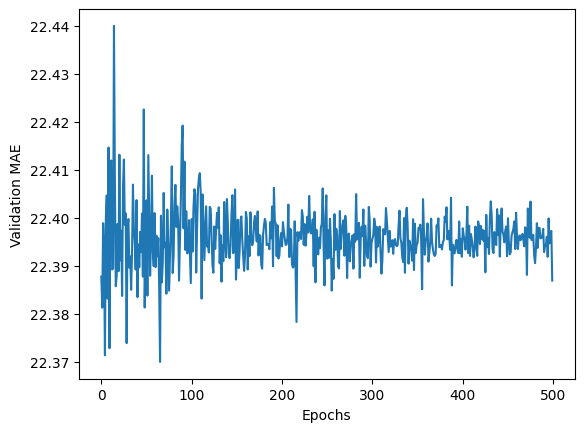

In [23]:
# Plotting validation scores
import matplotlib.pyplot as plt

plt.plot(average_mae_history)
plt.xlabel("Epochs")
plt.ylabel("Validation MAE")
plt.show()

In [27]:
# Training the final model
model = build_model()
model.fit(
    train_data, 
    train_targets,
    epochs=130, 
    batch_size=16,
    verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 13.5916 - mae: 2.7115 


In [33]:
model.predict(test_data)[10] # what is the models prediction for house 10 in the dataset

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


array([18.091183], dtype=float32)